<a href="https://colab.research.google.com/github/rsenthilk/awesome-datasets/blob/master/ARK_Fundamentals.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
from os import chdir
from glob import glob
import pandas as pdlib
import pandas as pd
import yfinance as yf
import requests
from io import StringIO
import numpy as np
import json
import matplotlib.pyplot as plt

from time import time, ctime

import sqlite3
from sqlalchemy import *

from bs4 import BeautifulSoup as soup
from urllib.request import Request, urlopen

from datetime import datetime

In [ ]:
pip install yfinance

In [27]:
#Global Constants

dbloc ='/home/alpha-research/sources/ark/ark.db'

dateTimeObj = datetime.now()
dateObj = dateTimeObj.date()
curr_date_str = str (dateObj.year)+"_" + str(dateObj.month) +"_" + str(dateObj.day)
print(curr_date_str)

#Finviz Ticker Master File 
finviz_ticker_master_file='/home/alpha-research/sources/finviz/finviz_ticker_master_20210403MC.csv'

#ARK Fund File locations
arkk = 'https://ark-funds.com/wp-content/fundsiteliterature/csv/ARK_INNOVATION_ETF_ARKK_HOLDINGS.csv'
arkq = 'https://ark-funds.com/wp-content/fundsiteliterature/csv/ARK_AUTONOMOUS_TECHNOLOGY_&_ROBOTICS_ETF_ARKQ_HOLDINGS.csv'
arkw = 'https://ark-funds.com/wp-content/fundsiteliterature/csv/ARK_NEXT_GENERATION_INTERNET_ETF_ARKW_HOLDINGS.csv'
arkg = 'https://ark-funds.com/wp-content/fundsiteliterature/csv/ARK_GENOMIC_REVOLUTION_MULTISECTOR_ETF_ARKG_HOLDINGS.csv'
arkf = 'https://ark-funds.com/wp-content/fundsiteliterature/csv/ARK_FINTECH_INNOVATION_ETF_ARKF_HOLDINGS.csv'
arkx = 'https://ark-funds.com/wp-content/fundsiteliterature/csv/ARK_SPACE_EXPLORATION_&_INNOVATION_ETF_ARKX_HOLDINGS.csv'
prnt = 'https://ark-funds.com/wp-content/fundsiteliterature/csv/THE_3D_PRINTING_ETF_PRNT_HOLDINGS.csv'
izrl = 'https://ark-funds.com/wp-content/fundsiteliterature/csv/ARK_ISRAEL_INNOVATIVE_TECHNOLOGY_ETF_IZRL_HOLDINGS.csv'

#ARK CSV Folder
ark_csv_base_folder='/home/alpha-research/sources/ark/'
finviz_csv_base_folder='/home/alpha-research/sources/finviz/'
finviz_all_ticker_file='finviz_ticker_master_20210403MC.csv'

2021_4_4


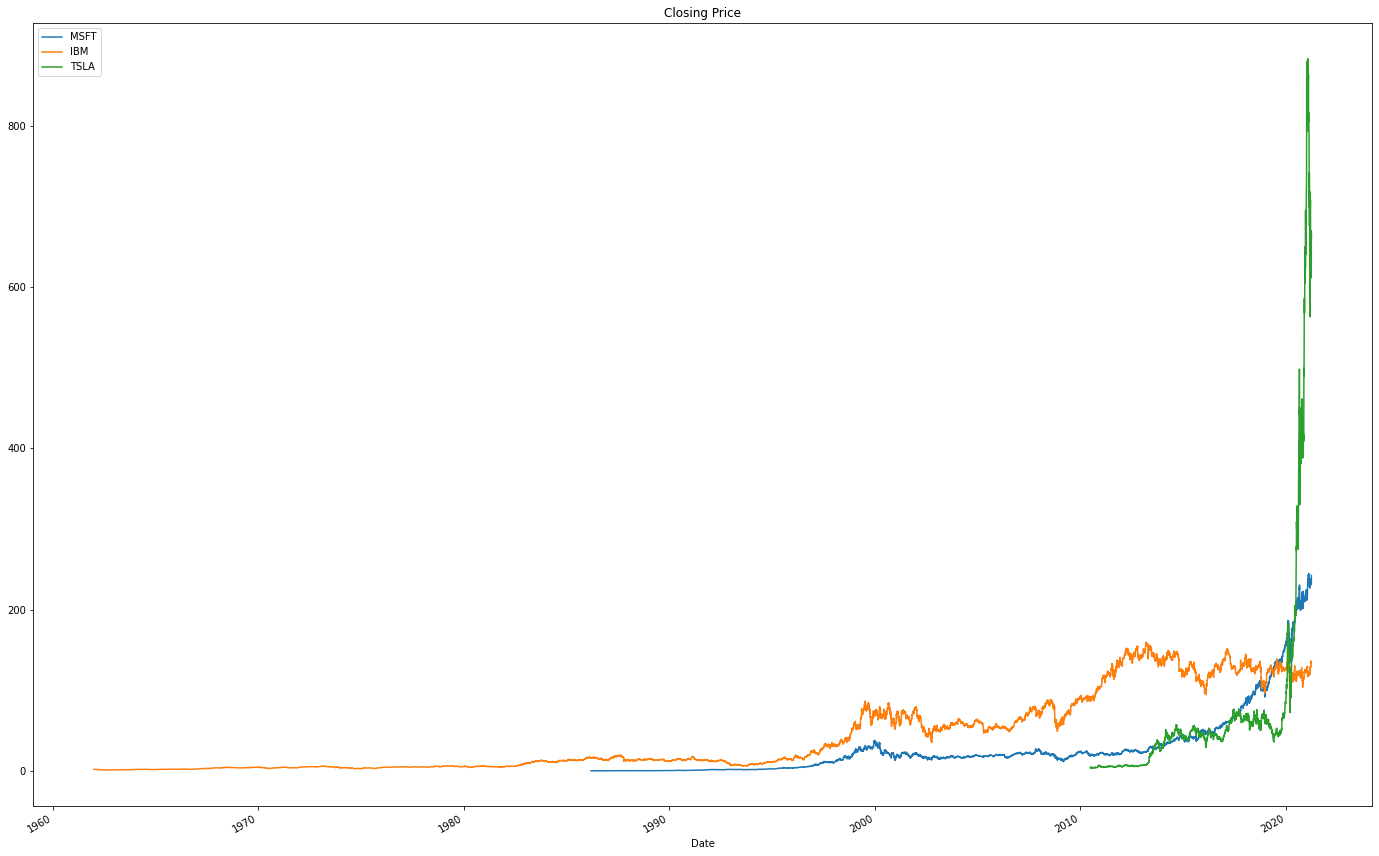

In [28]:
# Common Functions
def get_pricing_history(ticker_array) :
    try :
        df_ark_funds_pricing=pdlib.DataFrame()
        for symbol in ticker_array : 
            stock = yf.Ticker(symbol)
            curr_df = stock.history(period="max")
            curr_df['ticker'] = symbol
            df_ark_funds_pricing = df_ark_funds_pricing.append(curr_df)    
        return df_ark_funds_pricing
    except :
        print('Error  ' + symbol)

def get_pricing_chart(ticker_array) :
    try:
        df_fund_pricing=get_pricing_history(ticker_array)
        for ticker in ticker_array :
            df_fund_pricing.loc[df_fund_pricing['ticker'] == ticker]['Close'].plot(label=ticker,figsize=(24,16),title='Closing Price')
        plt.legend()
    except :
        print('Error  ' + symbol)
        
ticker_array = {"MSFT","IBM","TSLA"}        
get_pricing_chart(ticker_array)

In [29]:
#File locations of ARK updates
def loadARKCSVs() :
    ark_funds_array = np.array ([arkk,arkq,arkw,arkg,arkf,arkx,prnt,izrl])
    #ark_funds_array = np.array ([arkk,arkq])
    #ARK doesn't allow programmatic download
    headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/56.0.2924.76 Safari/537.36'}
    #Initialize Dataframe 
    allARK=[]
    #Load all the 8 fund files into a single file and remove the blank / commentary rows 

    for currCSV in ark_funds_array :
        csvARG=requests.get(currCSV, headers= headers).text
        currARK=pdlib.read_csv(StringIO(csvARG), sep=",")
        try :
           allARK = allARK.append(currARK.dropna())
        except :
           allARK = currARK.dropna()
    return allARK
ark_data =loadARKCSVs()

In [30]:
#Question 1 - How ARK fund is distributed by market value
pdlib.options.display.float_format = '{:,.2f}'.format
ark_data.groupby(['fund']).sum()

,shares,market value($),weight(%)
fund,,,
ARKF,"89,784,152.00","3,981,392,330.23",99.82
ARKG,"202,209,613.00","9,429,585,153.47",99.85
ARKQ,"56,366,423.00","3,337,942,976.64",99.87
ARKW,"85,540,466.00","6,872,660,316.87",99.88
ARKX,"5,106,266.00","344,147,017.57",98.90
IZRL,"43,696,114.00","340,311,864.83",99.56
PRNT,"11,512,886.00","561,570,488.99",99.05


In [31]:
#Question 2 - How many distinct stocks are there are across the ARK portfolio
ark_ticker_list=ark_data.ticker.unique()
print('Total Distinct Instruments [Stocks, ETFs..] '+ str(len(ark_ticker_list)))

Total Distinct Instruments [Stocks, ETFs..] 273


In [32]:
#Question 3 - How many are listed in US market vs. International
df_all_tickers=pd.read_csv(finviz_ticker_master_file)
df_all_tickers.head()
stocks_with_info_list =[]
stocks_without_info_list =[]

for symbol in ark_ticker_list :
    symbol_count=df_all_tickers['Ticker'].str.contains(symbol).sum()
    if symbol_count>0:
        stocks_with_info_list.append(symbol)
    else :
        stocks_without_info_list.append(symbol) 
        
print('Listed in US Market  ' + str(len(stocks_with_info_list)))
print('Not Listed in US Market ' + str(len(stocks_without_info_list)))

Listed in US Market  226
Not Listed in US Market 47


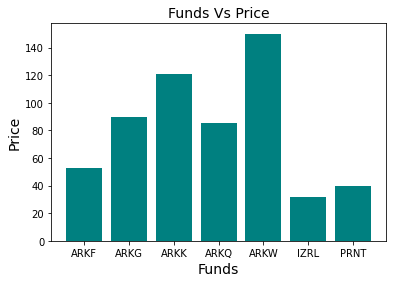

In [33]:
#Question 4 - How ARK funds compared to one another 
ark_funds_array={'ARKK','ARKQ','ARKW','ARKG','ARKF','ARKX','PRNT','IZRL'}
df_ark_funds=df_all_tickers.loc[df_all_tickers['Ticker'].isin(ark_funds_array)]

Funds = df_ark_funds['Ticker']
Price =  df_ark_funds['Price']

xAxis = [i + 0.5 for i, _ in enumerate(Funds)]
  
plt.bar(xAxis, Price, color='teal')
plt.title('Funds Vs Price', fontsize=14)
plt.xlabel('Funds', fontsize=14)
plt.ylabel('Price', fontsize=14)
plt.xticks([i + 0.5 for i, _ in enumerate(Funds)], Funds)
plt.show()

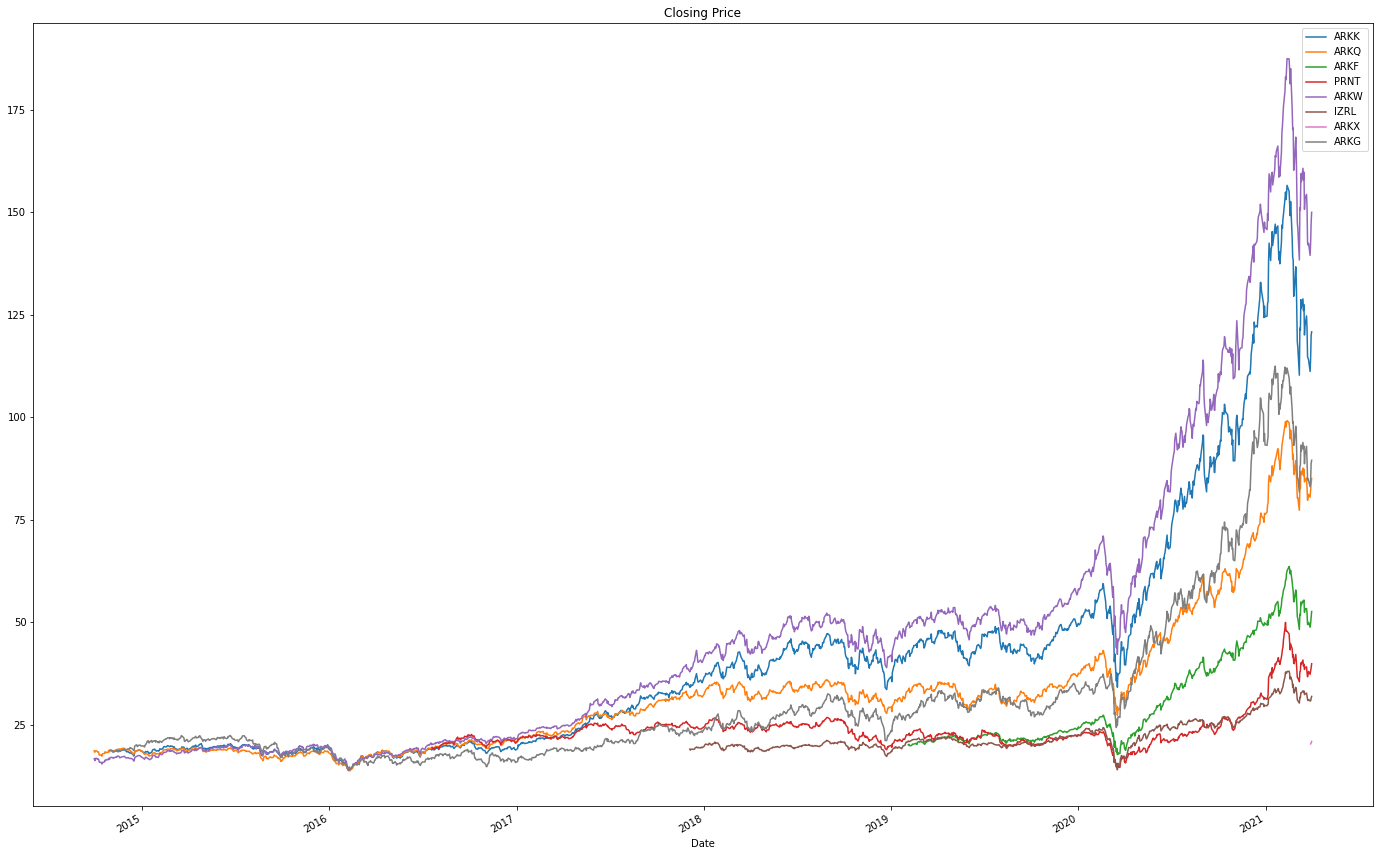

In [34]:
#Question 5 - How ARK Funds pricing performance look over the years
get_pricing_chart(ark_funds_array)

In [35]:
#Question 5 - Which sector has most capital allocation
df_ark_funds.groupby(['Sector']).sum()

,No.,Market Cap,P/E,Forward P/E,PEG,P/S,P/B,P/Cash,P/Free Cash Flow,EPS (ttm),Shares Outstanding,Shares Float,Short Ratio,Current Ratio,Quick Ratio,LT Debt/Equity,Total Debt/Equity,Beta,Average True Range,Relative Strength Index (14),Analyst Recom,Average Volume,Relative Volume,Price,Volume,Target Price,After-Hours Close
Sector,,,,,,,,,,,,,,,,,,,,,,,,,,,
Financial,11910,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,27.16,341.82,0.00,"26,877.13",4.73,569.80,22134177,0.00,571.62


In [36]:
#Question 6 - How ARK Funds Underlying instruments are performing

def p2f(x):
    try :
        x = float(x.strip('%'))
        return(x)
    except :
        return 0
all_tickers_csv_file=finviz_csv_base_folder+finviz_all_ticker_file
df_ark_all_tickers = pdlib.read_csv(all_tickers_csv_file,converters={'20-Day Simple Moving Average':p2f,'50-Day Simple Moving Average':p2f,'Profit Margin':p2f })
df_ark_all_tickers = df_ark_all_tickers[df_ark_all_tickers['Ticker'].isin(stocks_with_info_list)]

df_temp = df_ark_all_tickers.loc[ 
    #(df_ark_all_tickers['Sector'] =='Technology') &
    (df_ark_all_tickers['EPS (ttm)'] > 0) &
    (df_ark_all_tickers['Current Ratio'] > 1.5) 
    
    #(df_ark_all_tickers['20-Day Simple Moving Average'] > 0 ) &
    #(df_ark_all_tickers['50-Day Simple Moving Average'] > 0 )  
    #(df_ark_all_tickers['Price'] < 50 ) 
    #(df_ark_all_tickers['Relative Strength Index (14)'] < 50 ) 
    ]

Top 10 Instruments : 
     Ticker                  Sector  ...   P/S Profit Margin
354    AMZN       Consumer Cyclical  ...  4.12          5.50
3107   GOOG  Communication Services  ...  8.04          0.00
4567   MELI       Consumer Cyclical  ... 18.57          0.00
6434   SHOP              Technology  ... 48.63         10.90
3837   ISRG              Healthcare  ... 19.58         24.30
7166   TSLA       Consumer Cyclical  ... 20.14          2.20
7176    TTD              Technology  ... 36.35         29.00
5146   NVDA              Technology  ... 20.06         26.00
262    ALGN              Healthcare  ... 17.10         71.80
4961   NFLX  Communication Services  ...  9.46         11.00

[10 rows x 10 columns]


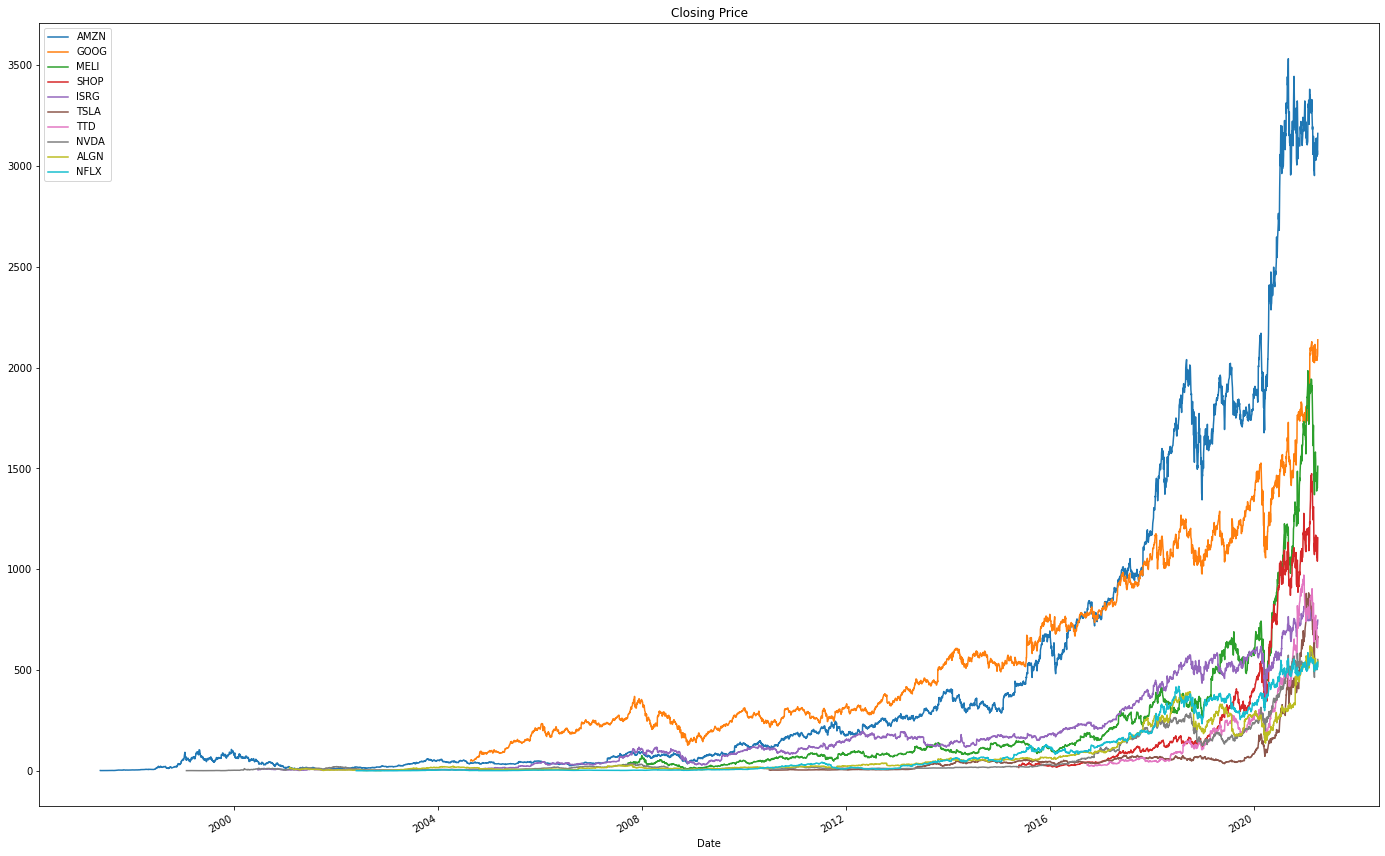

In [37]:
#Question 6.1 - Top 10 Instruments by price
print('Top 10 Instruments : ')
df_calc=(df_ark_all_tickers[['Ticker','Sector','Industry','Company','Market Cap','Price','P/E','PEG','P/S','Profit Margin']]).sort_values(by=['Price'], ascending=False).head(10)
print(df_calc)
ticker_array=df_calc['Ticker']
get_pricing_chart(ticker_array)

Bottom 10 Instruments : 
     Ticker                  Sector  ...      P/S Profit Margin
422     AQB      Consumer Defensive  ... 4,773.27          0.00
4131   KMDA              Healthcare  ...     2.08          0.00
1234   CERS              Healthcare  ...     8.54        -52.40
2353   EVGN              Healthcare  ...   244.83          0.00
5804   PTNR  Communication Services  ...     0.91          0.60
5780   PSTI              Healthcare  ...      nan          0.00
1046   BVXV              Healthcare  ...      nan          0.00
1574   CRNT              Technology  ...     1.18         -6.50
2356    EVK       Consumer Cyclical  ...     0.14         -1.10
5282    ONE      Consumer Defensive  ...     0.81        -24.00

[10 rows x 10 columns]


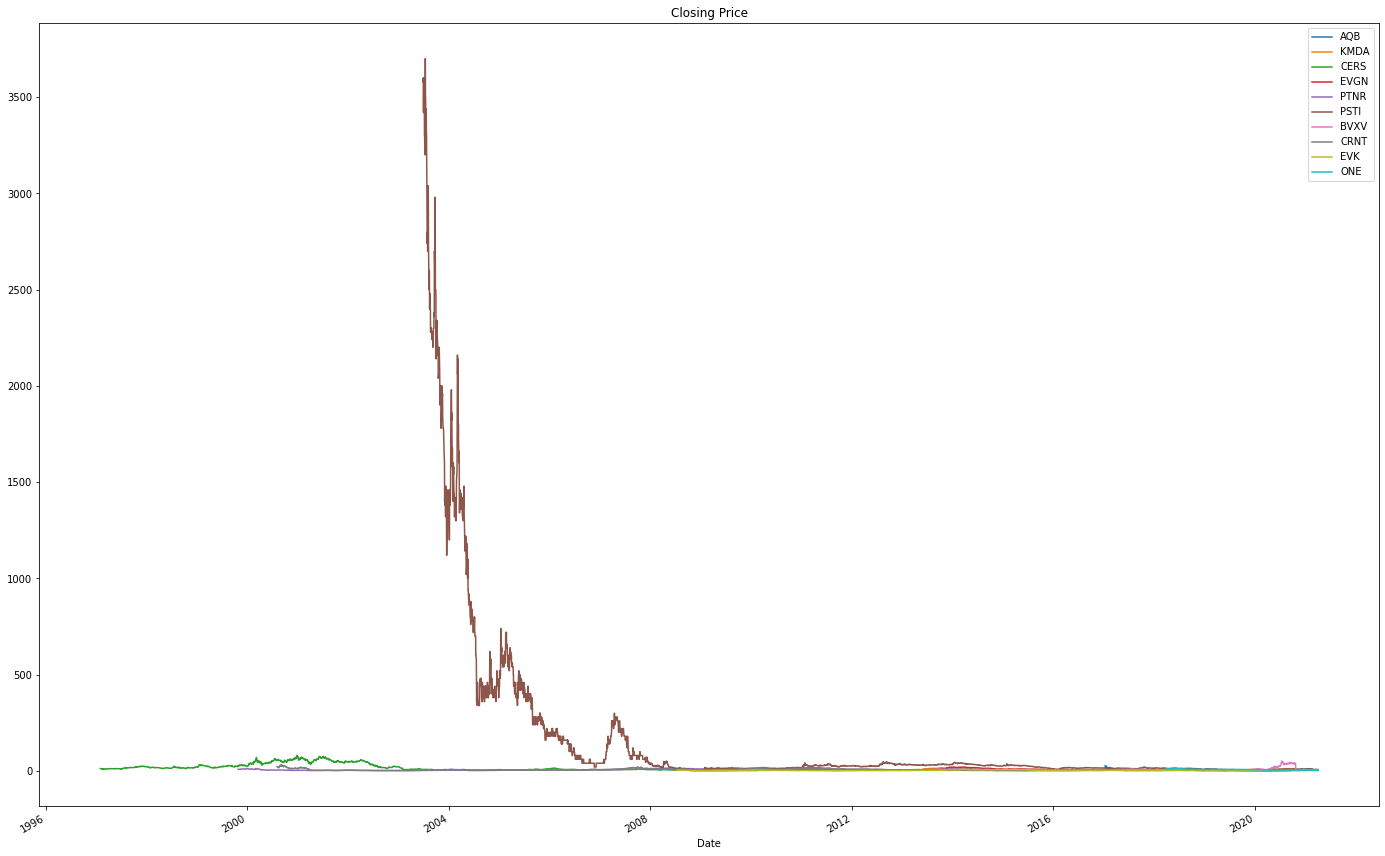

In [38]:
#Question 6.2 - Bottom 10 Instruments by price
print('Bottom 10 Instruments : ')
df_calc = (df_ark_all_tickers[['Ticker','Sector','Industry','Company','Market Cap','Price','P/E','PEG','P/S','Profit Margin']]).sort_values(by=['Price'], ascending=False).tail(10)
print(df_calc)
ticker_array=df_calc['Ticker']
get_pricing_chart(ticker_array)

Most Active 10 Instruments : 
     Ticker                  Sector  ...    P/S    Volume
15     AAPL              Technology  ...   6.98  74894534
2957     GE             Industrials  ...   1.45  58674678
5629   PLTR              Technology  ...  38.47  51322126
7166   TSLA       Consumer Cyclical  ...  20.14  35173688
4772   MSFT              Technology  ...  11.72  30267905
642    BABA       Consumer Cyclical  ...   6.04  23472314
5034   NNDM              Technology  ... 624.26  18480202
7168    TSM              Technology  ...  11.97  17829552
2458     FB  Communication Services  ...   9.74  17582262
6561   SNAP  Communication Services  ...  32.67  16090835

[10 rows x 10 columns]


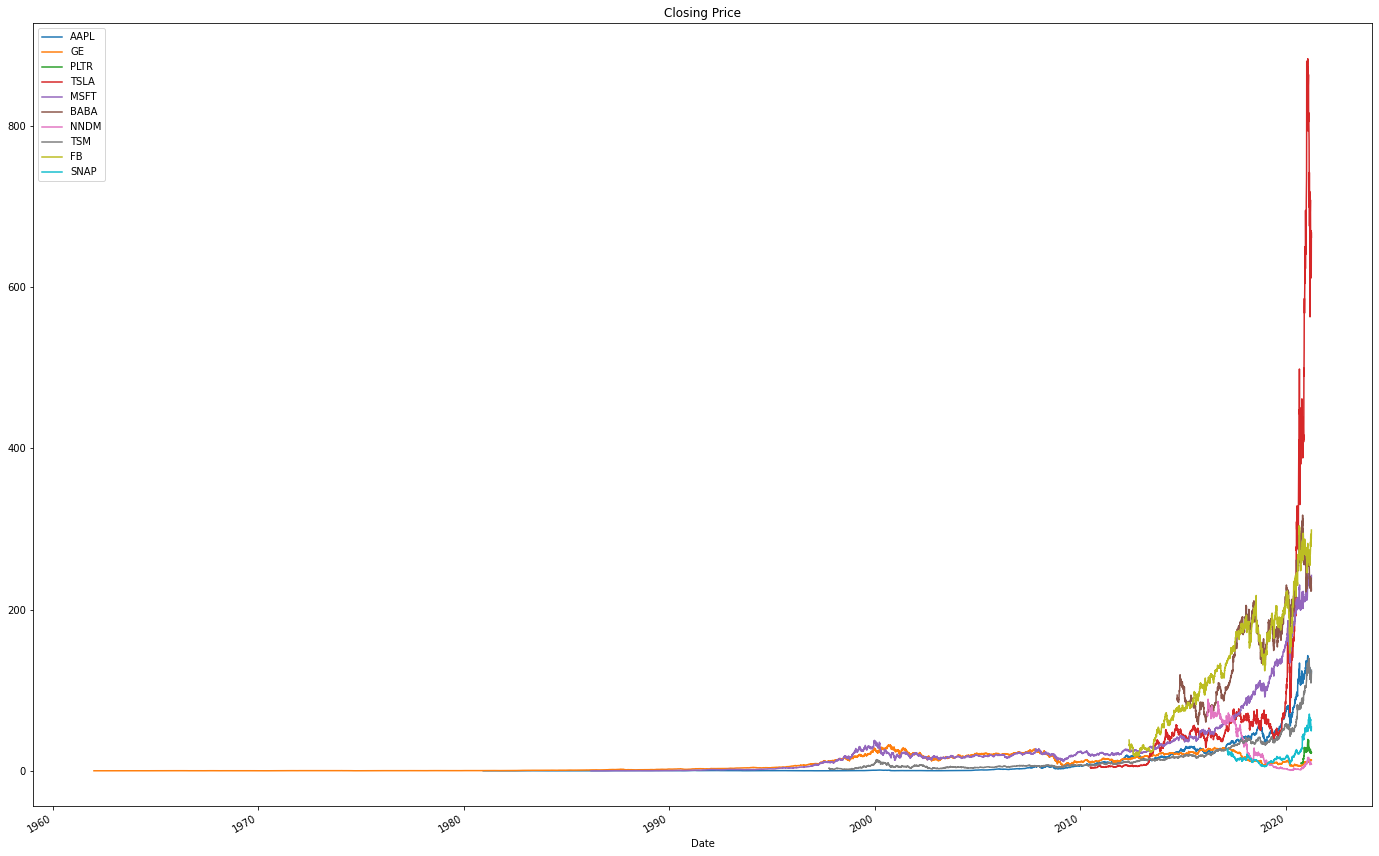

In [39]:
#Question 7.1 - What are the Top 10 most active Instruments 
print('Most Active 10 Instruments : ')
df_calc=(df_ark_all_tickers[['Ticker','Sector','Industry','Company','Market Cap','Price','P/E','PEG','P/S','Volume']]).sort_values(by=['Volume'], ascending=False).head(10)
print(df_calc)
ticker_array=df_calc['Ticker']
get_pricing_chart(ticker_array)

Least Active 10 Instruments : 
     Ticker                  Sector  ...  P/S Volume
2207   ENLV              Healthcare  ...  nan  75426
1046   BVXV              Healthcare  ...  nan  66286
4599   MGIC              Technology  ... 2.08  56623
2450   FARO              Technology  ... 5.02  52138
6901   TARO              Healthcare  ... 4.95  35146
2298   ESLT             Industrials  ... 1.33  31849
6458   SILC              Technology  ... 2.90  31653
5847   PYPD              Healthcare  ...  nan  25053
3855   ITMR              Healthcare  ... 9.30   9432
5804   PTNR  Communication Services  ... 0.91   1584

[10 rows x 10 columns]


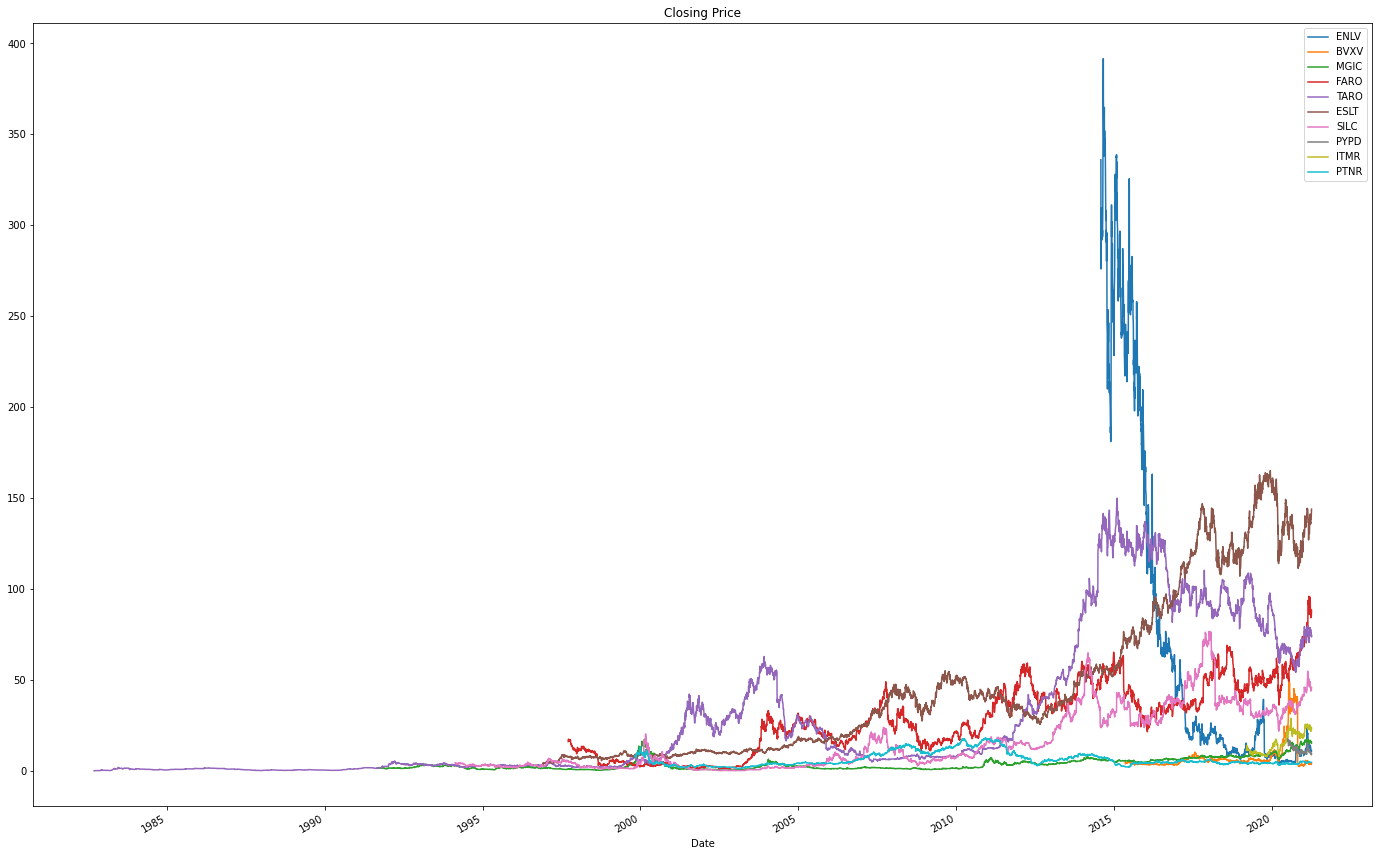

In [40]:
#Question 7.2 - What are the  10 least active Instruments 
print('Least Active 10 Instruments : ')
df_calc=(df_ark_all_tickers[['Ticker','Sector','Industry','Company','Market Cap','Price','P/E','PEG','P/S','Volume']]).sort_values(by=['Volume'], ascending=False).tail(10)
print(df_calc)
ticker_array=df_calc['Ticker']
get_pricing_chart(ticker_array)

Most Profitable 10 Instruments : 
     Ticker      Sector  ...   P/S Profit Margin
262    ALGN  Healthcare  ... 17.10         71.80
6822   SURF  Healthcare  ...  2.76         47.00
7601   VRTX  Healthcare  ...  8.83         43.70
4652   MKTX   Financial  ... 27.57         43.40
6007   REGN  Healthcare  ...  5.82         41.30
1300   CHKP  Technology  ...  7.58         41.00
7168    TSM  Technology  ... 11.97         38.70
5378   PACB  Healthcare  ... 82.26         37.30
3746   INMD  Healthcare  ... 14.05         36.40
3563    ICE   Financial  ... 10.50         34.60

[10 rows x 10 columns]


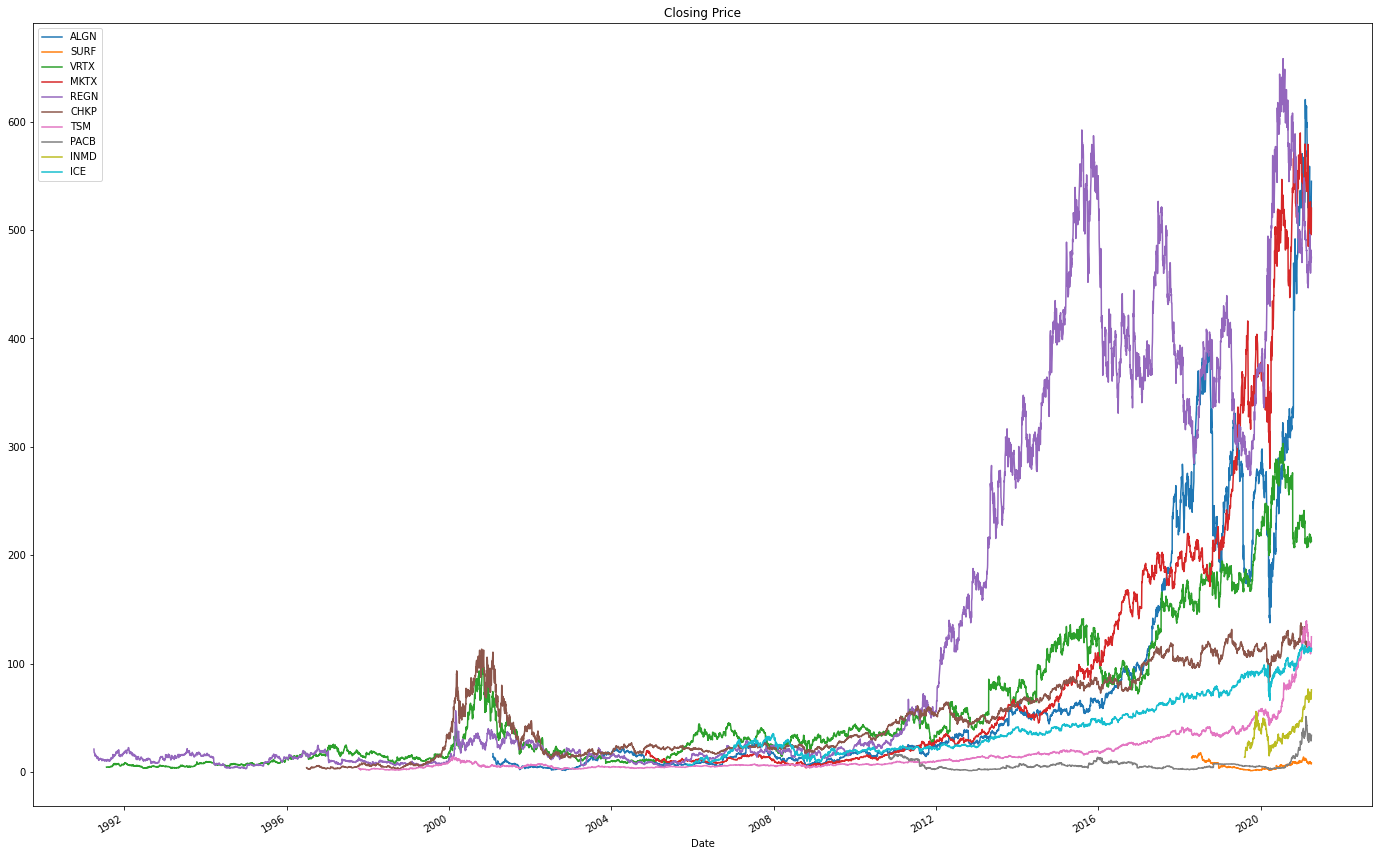

In [41]:
#Question 8.1 - What are the 10 most profitable Instruments 
print('Most Profitable 10 Instruments : ')
df_calc=(df_ark_all_tickers[['Ticker','Sector','Industry','Company','Market Cap','Price','P/E','PEG','P/S','Profit Margin']]).sort_values(by=['Profit Margin'], ascending=False).head(10)
print(df_calc)
ticker_array=df_calc['Ticker']
get_pricing_chart(ticker_array)

Least Profitable 10 Instruments : 
     Ticker                  Sector  ...   P/S Profit Margin
529     ATI             Industrials  ...  0.88        -52.70
6490   SKLZ  Communication Services  ... 32.77        -53.20
4151   KODK             Industrials  ...  0.62        -54.50
2405   EXAS              Healthcare  ... 15.04        -56.90
3774   IONS              Healthcare  ...  8.61        -61.90
6956   TEAM              Technology  ... 30.05        -65.80
858     BLI              Healthcare  ... 50.05        -67.40
6754   SSYS              Technology  ...  3.12        -85.20
2989     GH              Healthcare  ... 54.53        -88.50
5094   NSTG              Healthcare  ... 26.46        -93.80

[10 rows x 10 columns]


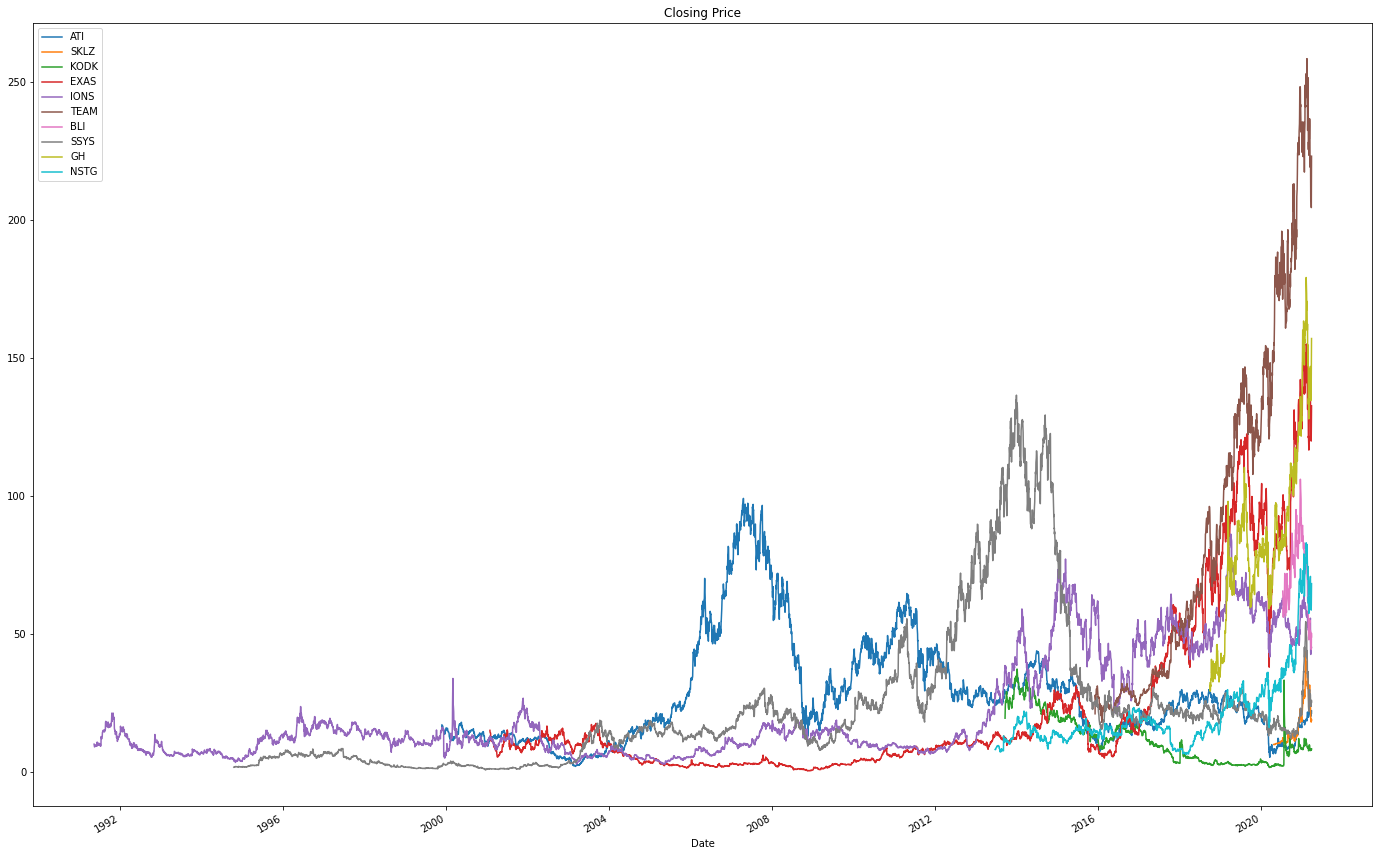

In [42]:
#Question 8.2 - What are the 10 most profitable Instruments 
print('Least Profitable 10 Instruments : ')
df_calc=(df_ark_all_tickers[['Ticker','Sector','Industry','Company','Market Cap','Price','P/E','PEG','P/S','Profit Margin']]).sort_values(by=['Profit Margin'], ascending=False).tail(10)
print(df_calc)
ticker_array=df_calc['Ticker']
get_pricing_chart(ticker_array)

Top 10 Instruments in Healthcare by Price : 
     Ticker      Sector  ...   P/S Profit Margin
3837   ISRG  Healthcare  ... 19.58         24.30
262    ALGN  Healthcare  ... 17.10         71.80
6007   REGN  Healthcare  ...  5.82         41.30
7066    TMO  Healthcare  ...  5.36         19.80
7446   VEEV  Healthcare  ... 27.14         22.40
6870    SYK  Healthcare  ...  6.22         11.10
7601   VRTX  Healthcare  ...  8.83         43.70
7214    TXG  Healthcare  ... 67.67          0.00
6943   TDOC  Healthcare  ... 25.41        -44.30
2989     GH  Healthcare  ... 54.53        -88.50

[10 rows x 10 columns]


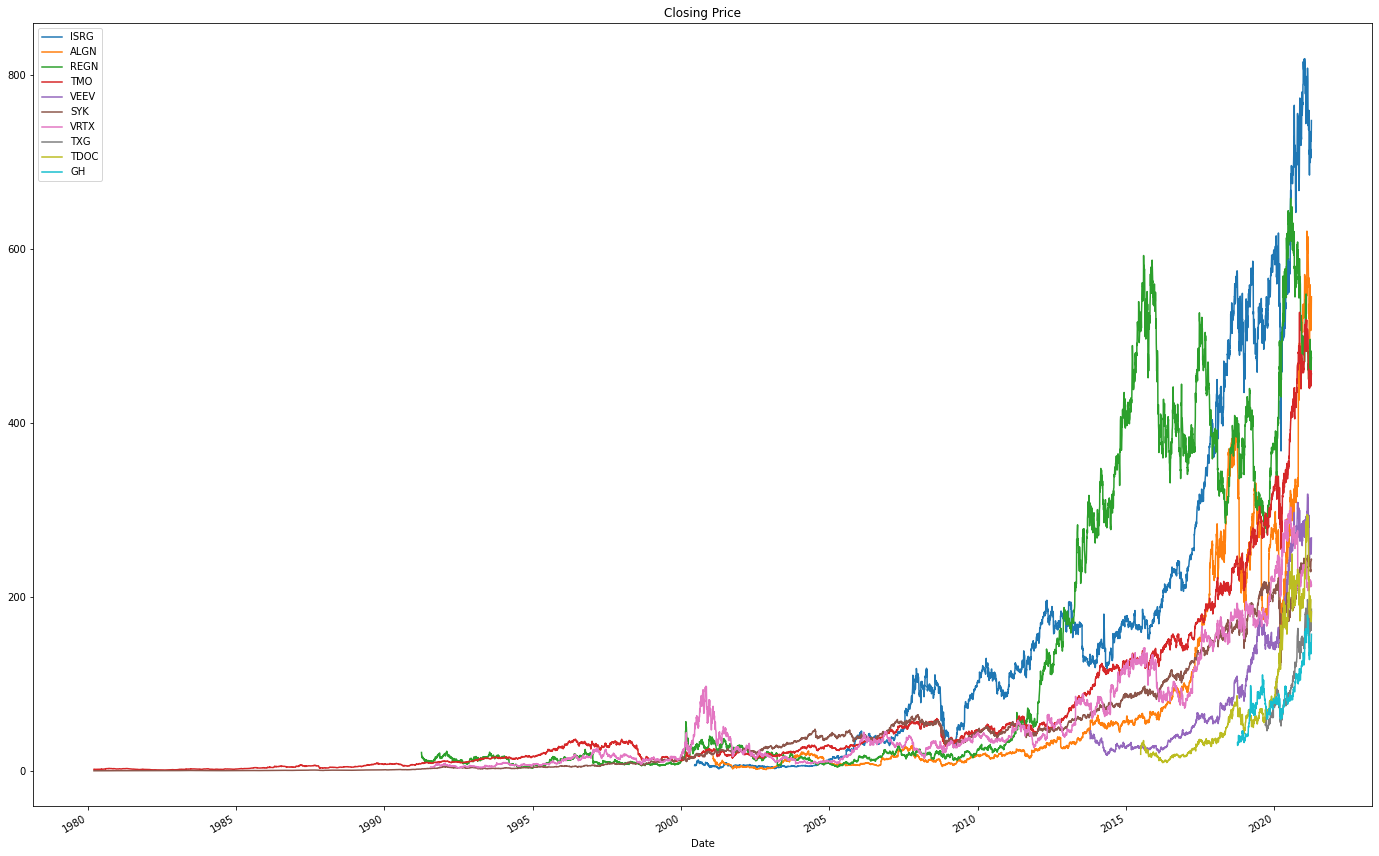

In [43]:
#Question 9 - How does the sector-wise investments looks like in Healthcare

df_ark_all_tickers = df_ark_all_tickers.loc[ (df_ark_all_tickers['Sector'] =='Healthcare')]
    
print('Top 10 Instruments in Healthcare by Price : ')
df_calc=(df_ark_all_tickers[['Ticker','Sector','Industry','Company','Market Cap','Price','P/E','PEG','P/S','Profit Margin']]).sort_values(by=['Price'], ascending=False).head(10)
print(df_calc)
ticker_array=df_calc['Ticker']
get_pricing_chart(ticker_array)

Bottom 10 Instruments in Healthcare by Price: 
     Ticker      Sector  ...    P/S Profit Margin
1267   CGEN  Healthcare  ... 375.48          0.00
3058   GMDA  Healthcare  ...    nan          0.00
6822   SURF  Healthcare  ...   2.76         47.00
5985   RDHL  Healthcare  ...   5.45          0.00
6879   SYRS  Healthcare  ...  30.94          0.00
4131   KMDA  Healthcare  ...   2.08          0.00
1234   CERS  Healthcare  ...   8.54        -52.40
2353   EVGN  Healthcare  ... 244.83          0.00
5780   PSTI  Healthcare  ...    nan          0.00
1046   BVXV  Healthcare  ...    nan          0.00

[10 rows x 10 columns]


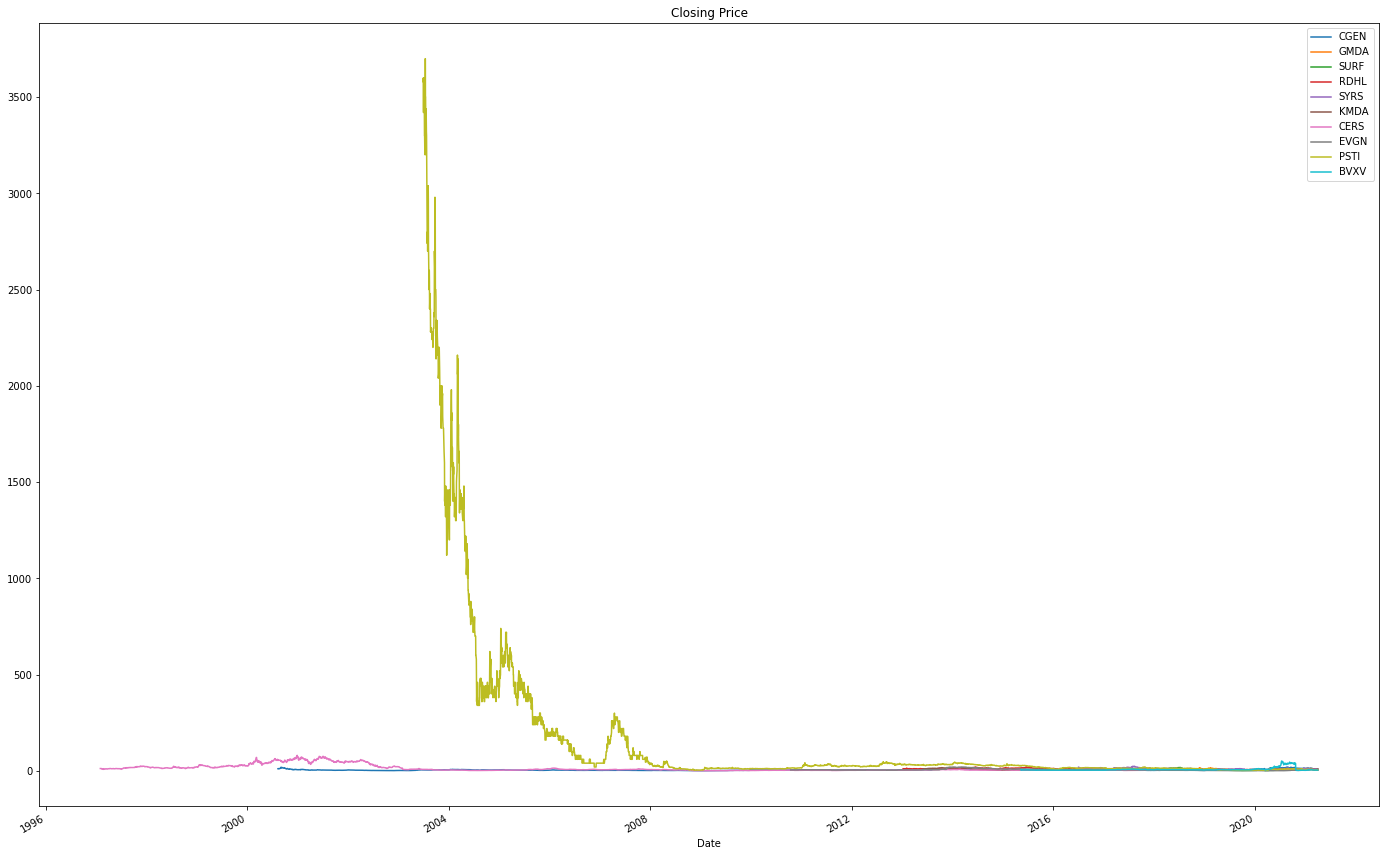

In [44]:
#Question 9.1
print('Bottom 10 Instruments in Healthcare by Price: ')
df_calc=(df_ark_all_tickers[['Ticker','Sector','Industry','Company','Market Cap','Price','P/E','PEG','P/S','Profit Margin']]).sort_values(by=['Price'], ascending=False).tail(10)
print(df_calc)
ticker_array=df_calc['Ticker']
get_pricing_chart(ticker_array)

Most Active 10 Instruments in Healthcare : 
     Ticker      Sector  ...   P/S   Volume
891     BMY  Healthcare  ...  3.26  9724585
3778   IOVA  Healthcare  ...   nan  5669470
5162   NVTA  Healthcare  ... 27.73  5383376
22     ABBV  Healthcare  ...  4.10  5089491
6978   TEVA  Healthcare  ...  0.73  3930545
759    BFLY  Healthcare  ... 64.89  3500382
5378   PACB  Healthcare  ... 82.26  3435464
6943   TDOC  Healthcare  ... 25.41  2816018
1234   CERS  Healthcare  ...  8.54  2586639
7601   VRTX  Healthcare  ...  8.83  2071108

[10 rows x 10 columns]


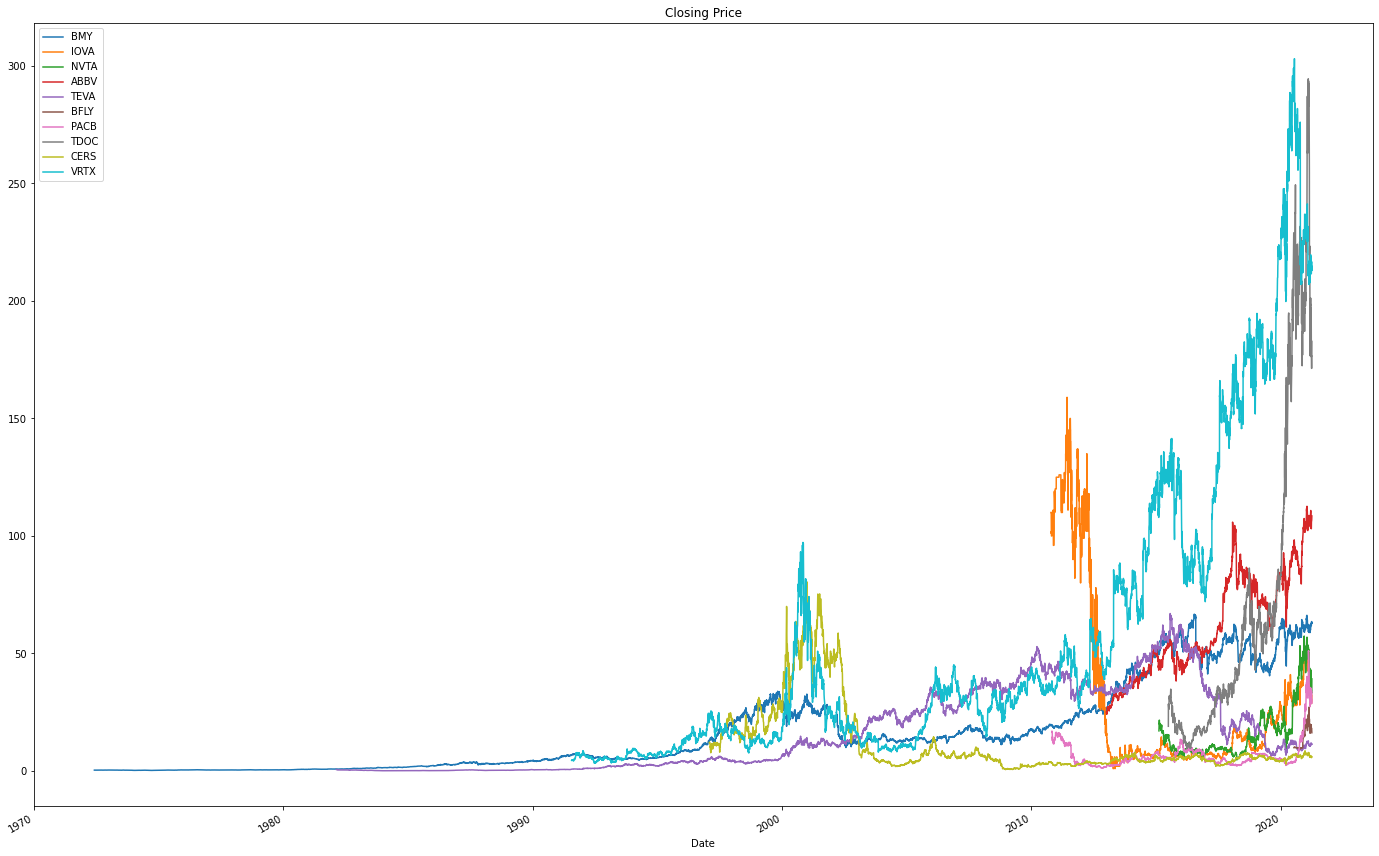

In [45]:
#Question 9.2
print('Most Active 10 Instruments in Healthcare : ')
df_calc=(df_ark_all_tickers[['Ticker','Sector','Industry','Company','Market Cap','Price','P/E','PEG','P/S','Volume']]).sort_values(by=['Volume'], ascending=False).head(10)
print(df_calc)
ticker_array=df_calc['Ticker']
get_pricing_chart(ticker_array)

Least Active 10 Instruments in Healthcare : 
     Ticker      Sector  ...       P/S  Volume
4490   MASS  Healthcare  ...     48.81  247495
1940   DRIO  Healthcare  ...     40.95  131099
6164   RPTX  Healthcare  ... 11,838.33  111865
5985   RDHL  Healthcare  ...      5.45  110420
4131   KMDA  Healthcare  ...      2.08   83387
2207   ENLV  Healthcare  ...       nan   75426
1046   BVXV  Healthcare  ...       nan   66286
6901   TARO  Healthcare  ...      4.95   35146
5847   PYPD  Healthcare  ...       nan   25053
3855   ITMR  Healthcare  ...      9.30    9432

[10 rows x 10 columns]


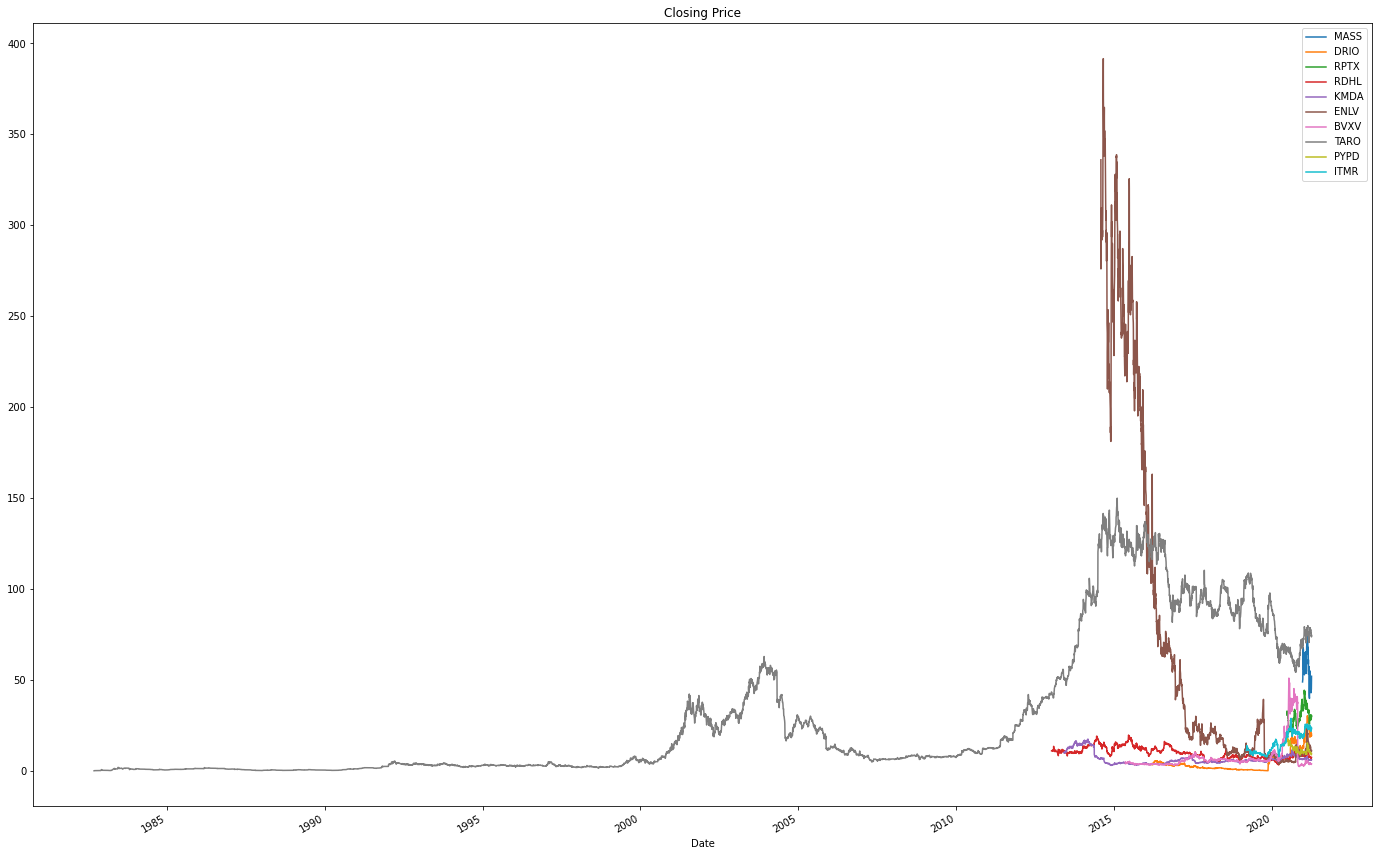

In [46]:
#Question 9.3
print('Least Active 10 Instruments in Healthcare : ')
df_calc=(df_ark_all_tickers[['Ticker','Sector','Industry','Company','Market Cap','Price','P/E','PEG','P/S','Volume']]).sort_values(by=['Volume'], ascending=False).tail(10)
print(df_calc)
ticker_array=df_calc['Ticker']
get_pricing_chart(ticker_array)

Most Profitable 10 Instruments in Healthcare: 
     Ticker      Sector  ...   P/S Profit Margin
262    ALGN  Healthcare  ... 17.10         71.80
6822   SURF  Healthcare  ...  2.76         47.00
7601   VRTX  Healthcare  ...  8.83         43.70
6007   REGN  Healthcare  ...  5.82         41.30
5378   PACB  Healthcare  ... 82.26         37.30
3746   INMD  Healthcare  ... 14.05         36.40
3837   ISRG  Healthcare  ... 19.58         24.30
7446   VEEV  Healthcare  ... 27.14         22.40
7066    TMO  Healthcare  ...  5.36         19.80
5158    NVS  Healthcare  ...  4.25         16.20

[10 rows x 10 columns]


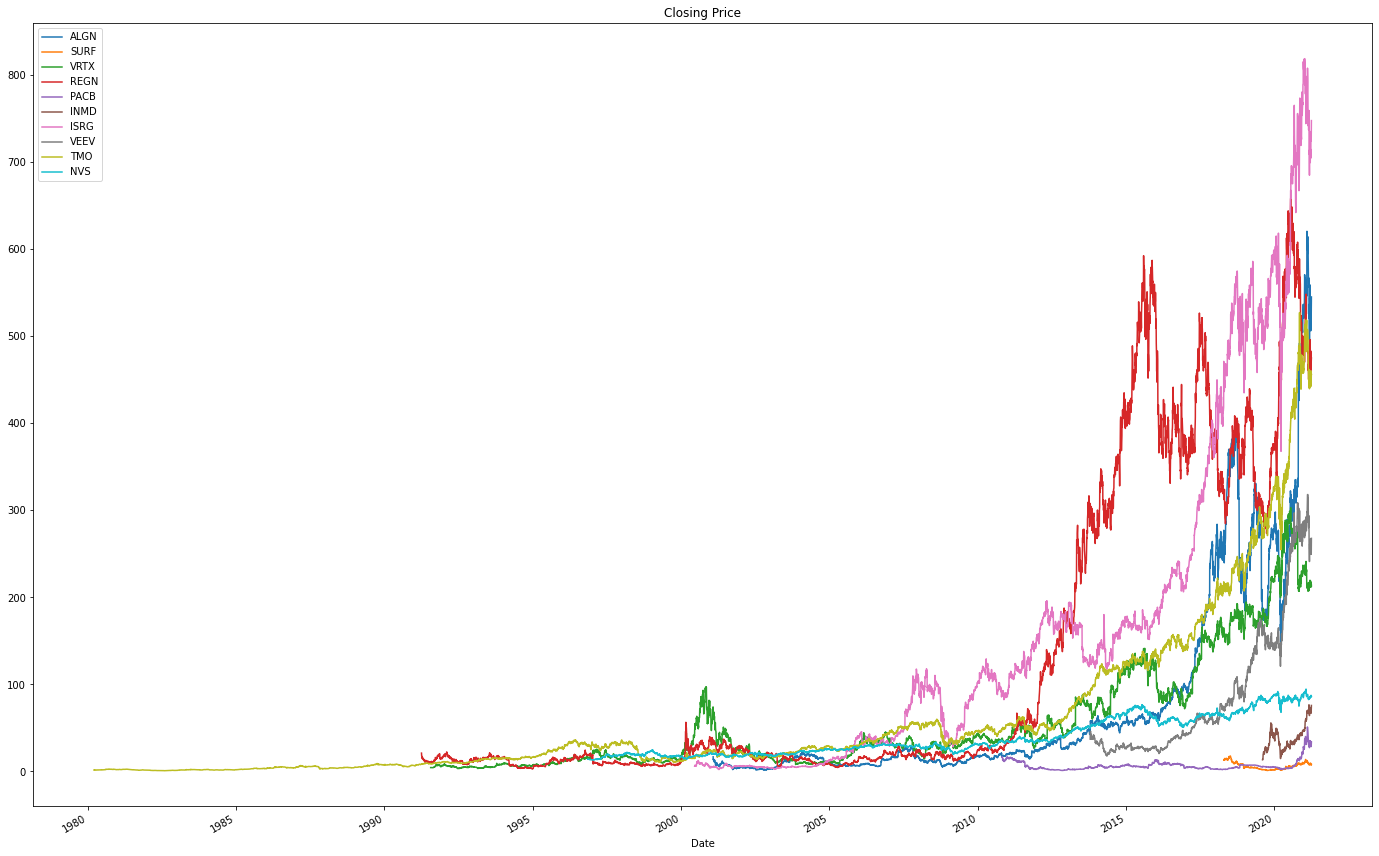

In [47]:
#Question 9.4
print('Most Profitable 10 Instruments in Healthcare: ')
df_calc=(df_ark_all_tickers[['Ticker','Sector','Industry','Company','Market Cap','Price','P/E','PEG','P/S','Profit Margin']]).sort_values(by=['Profit Margin'], ascending=False).head(10)
print(df_calc)
ticker_array=df_calc['Ticker']
get_pricing_chart(ticker_array)

In [ ]:
#Question 9.5
print('Least Profitable 10 Instruments in Healthcare: ')
df_calc=(df_ark_all_tickers[['Ticker','Sector','Industry','Company','Market Cap','Price','P/E','PEG','P/S','Profit Margin']]).sort_values(by=['Profit Margin'], ascending=False).tail(10)
print(df_calc)
ticker_array=df_calc['Ticker']
get_pricing_chart(ticker_array)